# Project Milestone 2 Notebook
## Do Americans prefer beers with a higher alcohol content (ABV) than Europeans?
- Is there a correlation between this preference and specific beer styles known for higher ABV?
We will use grouping techniques and micro/macro averages to analyse this preference.
- How have beer preferences, especially in terms of ABV, evolved in America and Europe between 2000 and 2017?
To analyse this question, we will use time series analysis and visualisation techniques.
- Is it possible to map American states to European countries based on similarities in beer preferences?
How can graph and network algorithms be utilized to explore these geographical correlations?

## 1. Imports and global variables

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_data import load_gzip_txt_data

## 2. Preprocessing of the data:

#### 2.1 Split users between North America and Europe:

Define European countries:

In [56]:
european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus",
    "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
    "Czech Republic", "Denmark", "England", "Estonia", "Finland", "France", "Georgia",
    "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Jersey", "Kazakhstan",
    "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta",
    "Moldova", "Monaco", "Montenegro", "Netherlands", "Northern Ireland", "Macedonia",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Scotland", "Serbia",
    "Slovakia", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey",
    "Ukraine", "Vatican City", "Wales"
]

# /!\ Slovakia in RateBeer and Slovak Republic in BeerAdvocate /!\

Load users files and classify if European, North American or neither:

In [57]:
def get_na_or_eu(row):
    """
    In a Dataframe with a column "location", returns whether the location 
    is in Europe or North America.
    
    :param row: pandas.Dataframe row with an attribute "location".
    :return: str, can be "NA", "EU" or "Other".
    """
    location = row['location']
    if location in european_countries:
        return 'EU'
    elif (location == 'Canada') or ("United States" in str(location)):
        return 'NA'
    else:
        return 'Other'


ba_users_df = pd.read_csv("./data/BeerAdvocate/users.csv")[['user_id', 'location']].dropna()
ba_users_df['eu_na'] = ba_users_df.apply(get_na_or_eu, axis=1)

rb_users_df = pd.read_csv("./data/RateBeer/users.csv")[['user_id', 'location']].dropna()
rb_users_df['eu_na'] = rb_users_df.apply(get_na_or_eu, axis=1)

print("BeerAdvocate:")
display(ba_users_df)
print("RateBeer:")
display(rb_users_df)

BeerAdvocate:


,user_id,location,eu_na
0,nmann08.184925,"United States, Washington",NA
1,stjamesgate.163714,"United States, New York",NA
2,mdagnew.19527,Northern Ireland,EU
3,helloloser12345.10867,Northern Ireland,EU
4,cypressbob.3708,Northern Ireland,EU
...,...,...,...
153698,eturchick.374415,"United States, California",NA
153699,everman.532342,"United States, California",NA
153700,justin0001.352175,"United States, California",NA
153702,joetex.800347,"United States, California",NA


RateBeer:


,user_id,location,eu_na
0,175852,Poland,EU
1,442761,Spain,EU
2,288889,Poland,EU
3,250510,Spain,EU
4,122778,Germany,EU
...,...,...,...
70167,181614,Norway,EU
70169,134893,England,EU
70170,327816,Belgium,EU
70172,82020,Slovenia,EU


Let's analyze the repartition of NA/EU/Other users:

In [58]:
print("BeerAdvocate:")
display(ba_users_df['eu_na'].value_counts())
print("RateBeer:")
display(rb_users_df['eu_na'].value_counts())

BeerAdvocate:


eu_na
NA       116547
EU         3944
Other      1934
Name: count, dtype: int64

RateBeer:


eu_na
NA       30110
EU       16156
Other     4326
Name: count, dtype: int64

Clearly, the vast majority of users comes from North America, followed by Europe especially in the BeerAdvocate dataset. In the following analysis, we will only consider NA and EU users.


In [59]:
ba_users_df = ba_users_df.query("eu_na != 'Other'")
rb_users_df = rb_users_df.query("eu_na != 'Other'")

#### 2.2 Load the ratings:

Load the ratings files:

In [60]:
ba_ratings_df = load_gzip_txt_data("./data/BeerAdvocate/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])
rb_ratings_df = load_gzip_txt_data("./data/RateBeer/ratings.txt.gz",
                                   ["user_id", "date", "abv", "style", "rating", "appearance", "aroma", "palate",
                                    "taste", "overall"])

Loading data from:  ./data/BeerAdvocate/ratings.txt.gz


151074576it [02:42, 929551.20it/s] 


Loading data from:  ./data/RateBeer/ratings.txt.gz


121075258it [02:19, 870029.06it/s]


Cast the columns to meaningful types:

In [61]:
ba_ratings_df = ba_ratings_df.astype({
    'user_id': 'str',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32',
    'appearance': 'float32',
    'aroma': 'float32',
    'palate': 'float32',
    'taste': 'float32',
    'overall': 'float32'})

rb_ratings_df = rb_ratings_df.astype({
    'user_id': 'int64',
    'date': 'int64',
    'abv': 'float32',
    'rating': 'float32',
    'appearance': 'float32',
    'aroma': 'float32',
    'palate': 'float32',
    'taste': 'float32',
    'overall': 'float32'})

# Convert the dates to monthly periods (useful for plotting):
ba_ratings_df['date'] = pd.to_datetime(ba_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')
rb_ratings_df['date'] = pd.to_datetime(rb_ratings_df['date'], unit='s').dt.to_period('m').astype('datetime64[M]')

#### 2.3 Group similar beer styles into broader groups

Defined the broad groups using https://www.beeradvocate.com/beer/styles/, so we can just load the csv file containing the matching specific type -> general type:

In [62]:
beer_styles_matching = pd.read_csv("./data/additional/styles_matching.csv", index_col='specific')['general'].to_dict()
print(f"General styles:\n{set(beer_styles_matching.values())}")

General styles:
{'Stouts', 'Porters', 'Brown Ales', 'Bocks', 'Wild/Sour Beers', 'Pale Ales', 'Dark Ales', 'Dark Lagers', 'Pale Lagers', 'Wheat Beers', 'Hybrid Beers', 'India Pale Ales', 'Specialty Beers', 'Strong Ales', 'Saké'}


Note: we don't want to take the Saké into account as it is not a beer!

Replace the specific beer style by the general style (and drop Saké ratings):

In [63]:
def specific_style_to_general(row):
    return beer_styles_matching[row['style']]

In [64]:
ba_ratings_df['style'] = ba_ratings_df.apply(specific_style_to_general, axis=1)
rb_ratings_df['style'] = rb_ratings_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_ratings_df = ba_ratings_df.query("style != 'Saké'")
rb_ratings_df = rb_ratings_df.query("style != 'Saké'")

In [65]:
print("BeerAdvocate:")
display(ba_ratings_df.sample(10))
print("RateBeer:")
display(rb_ratings_df.sample(10))

BeerAdvocate:


,user_id,date,abv,style,rating,appearance,aroma,palate,taste,overall
4645941,hozersr.799427,2017-07-01,6.5,India Pale Ales,4.09,3.75,4.00,4.00,4.25,4.00
1824632,h4ger.563156,2014-07-01,6.8,India Pale Ales,4.00,NaN,NaN,NaN,NaN,NaN
6076537,fl_chuck.777056,2015-01-01,10.8,India Pale Ales,4.77,5.00,4.25,5.00,5.00,4.75
6599720,hollandtunnels.638473,2013-09-01,7.0,India Pale Ales,4.75,NaN,NaN,NaN,NaN,NaN
4877487,dewsby.798319,2016-03-01,8.6,Porters,3.47,3.75,3.50,3.00,3.50,3.50
7468221,mbmiche.843284,2015-08-01,10.1,Stouts,4.35,4.25,4.25,4.25,4.50,4.25
7358293,jcugafsu.764299,2015-12-01,5.8,Wild/Sour Beers,4.43,4.75,4.25,4.25,4.50,4.50
7294493,daftpatrick.639745,2014-05-01,8.5,Stouts,4.25,NaN,NaN,NaN,NaN,NaN
775406,woodbrew.549902,2016-11-01,NaN,Pale Lagers,3.00,3.00,3.00,3.00,3.00,3.00
7901330,philipquarles.153371,2008-11-01,6.5,Pale Ales,4.57,4.50,5.00,4.00,4.50,4.50


RateBeer:


,user_id,date,abv,style,rating,appearance,aroma,palate,taste,overall
1339143,137798,2013-08-01,4.9,Wheat Beers,3.5,4.0,6.0,4.0,6.0,15.0
2494180,160645,2014-01-01,6.5,Strong Ales,3.1,5.0,6.0,3.0,5.0,12.0
1229583,17095,2013-08-01,4.8,Pale Lagers,2.1,3.0,4.0,2.0,4.0,8.0
2405769,266413,2016-12-01,5.2,Pale Ales,3.0,3.0,5.0,3.0,5.0,14.0
2331150,309464,2015-04-01,5.2,Stouts,2.9,3.0,6.0,3.0,5.0,12.0
600189,262336,2017-06-01,7.0,Stouts,3.8,3.0,8.0,4.0,7.0,16.0
5297078,50249,2008-07-01,NaN,Hybrid Beers,2.5,2.0,6.0,2.0,5.0,10.0
5651849,29087,2006-02-01,4.8,Pale Lagers,3.8,4.0,7.0,4.0,7.0,16.0
3648544,241596,2017-07-01,4.0,Wild/Sour Beers,3.3,2.0,7.0,3.0,7.0,14.0
1091329,28282,2012-01-01,4.9,Pale Lagers,2.6,3.0,5.0,3.0,5.0,10.0


#### 2.4 Merge the users with the ratings

In [66]:
ba_df = ba_ratings_df.merge(ba_users_df, on='user_id').drop(columns=['user_id'])
rb_df = rb_ratings_df.merge(rb_users_df, on='user_id').drop(columns=['user_id'])

In [67]:
print("BeerAdvocate:")
display(ba_df)
print("RateBeer:")
display(rb_df)

BeerAdvocate:


,date,abv,style,rating,appearance,aroma,palate,taste,overall,location,eu_na
0,2015-08-01,4.5,Pale Lagers,2.88,3.25,2.75,3.25,2.75,3.00,"United States, Washington",NA
1,2015-11-01,5.0,Pale Ales,3.56,4.00,3.50,3.75,3.50,3.50,"United States, Washington",NA
2,2011-11-01,8.0,Strong Ales,4.50,NaN,NaN,NaN,NaN,NaN,"United States, Washington",NA
3,2013-05-01,10.5,Strong Ales,3.75,NaN,NaN,NaN,NaN,NaN,"United States, Washington",NA
4,2015-01-01,6.0,Porters,3.81,4.00,3.50,3.75,4.00,3.75,"United States, Washington",NA
...,...,...,...,...,...,...,...,...,...,...,...
7806408,2012-01-01,10.1,India Pale Ales,1.00,NaN,NaN,NaN,NaN,NaN,"United States, California",NA
7806409,2014-04-01,10.1,India Pale Ales,4.54,4.75,4.50,4.75,4.50,4.50,"United States, California",NA
7806410,2011-06-01,8.0,India Pale Ales,2.08,3.00,2.50,3.00,1.50,2.00,"United States, California",NA
7806411,2014-05-01,6.0,Pale Ales,4.45,3.50,4.00,4.75,4.75,4.50,"United States, California",NA


RateBeer:


,date,abv,style,rating,appearance,aroma,palate,taste,overall,location,eu_na
0,2016-04-01,5.0,Pale Lagers,2.0,2.0,4.0,2.0,4.0,8.0,Poland,EU
1,2015-05-01,5.2,Pale Lagers,1.7,2.0,4.0,2.0,3.0,6.0,Poland,EU
2,2015-04-01,4.5,Pale Lagers,1.9,3.0,4.0,2.0,4.0,6.0,Poland,EU
3,2015-04-01,5.3,Brown Ales,3.7,4.0,7.0,4.0,8.0,14.0,Poland,EU
4,2015-11-01,6.1,Brown Ales,2.5,4.0,6.0,3.0,5.0,7.0,Poland,EU
...,...,...,...,...,...,...,...,...,...,...,...
6636932,2014-07-01,5.0,Pale Lagers,2.6,3.0,3.0,3.0,5.0,12.0,Belgium,EU
6636933,2008-09-01,4.7,Pale Lagers,0.5,1.0,1.0,1.0,1.0,1.0,Slovenia,EU
6636934,2008-09-01,4.5,Dark Lagers,3.9,4.0,7.0,5.0,6.0,17.0,Slovenia,EU
6636935,2008-09-01,4.0,Pale Lagers,2.7,5.0,4.0,3.0,5.0,10.0,Slovenia,EU


In [68]:
del ba_ratings_df
del ba_users_df
del rb_ratings_df
del rb_users_df

#### 2.5 Get the general style of all beers

Load all beers and keep only the (specific) style and the ABV:

In [69]:
ba_style_abv_df = pd.read_csv("./data/BeerAdvocate/beers.csv")[['style', 'abv']].dropna()
rb_style_abv_df = pd.read_csv("./data/RateBeer/beers.csv")[['style', 'abv']].dropna()

Convert the specific style to the general style:

In [70]:
ba_style_abv_df['style'] = ba_style_abv_df.apply(specific_style_to_general, axis=1)
rb_style_abv_df['style'] = rb_style_abv_df.apply(specific_style_to_general, axis=1)

# Drop Saké
ba_style_abv_df = ba_style_abv_df.query("style != 'Saké'")
rb_style_abv_df = rb_style_abv_df.query("style != 'Saké'")

In [71]:
print("BeerAdvocate:")
display(ba_style_abv_df.sample(10))
print("RateBeer:")
display(rb_style_abv_df.sample(10))

BeerAdvocate:


,style,abv
197778,Pale Ales,7.0
212144,Wild/Sour Beers,3.6
9260,Specialty Beers,4.1
76805,India Pale Ales,6.5
46569,Pale Lagers,4.0
183584,Pale Ales,5.0
207529,Stouts,7.2
13744,India Pale Ales,4.0
42741,Pale Lagers,5.0
218860,Dark Ales,7.6


RateBeer:


,style,abv
140085,Pale Lagers,5.00
438471,Stouts,8.00
59817,Pale Ales,5.40
271619,Specialty Beers,5.50
23775,Strong Ales,8.50
28098,India Pale Ales,6.10
266249,India Pale Ales,6.24
29612,Pale Ales,5.00
297839,Pale Ales,6.00
290275,Bocks,9.00


## 3. General Analysis 

In [72]:
sns.set_theme()
hue_order = ['NA', 'EU']
hue_order_styles = rb_df["style"].unique()

#### 3.1 ABV and ratings between NA and EU

Let's check the number of reviews per rounded ABV:

[None, Text(0.5, 1.0, 'RateBeer'), Text(0.5, 0, 'Alcohol by volume [%]')]

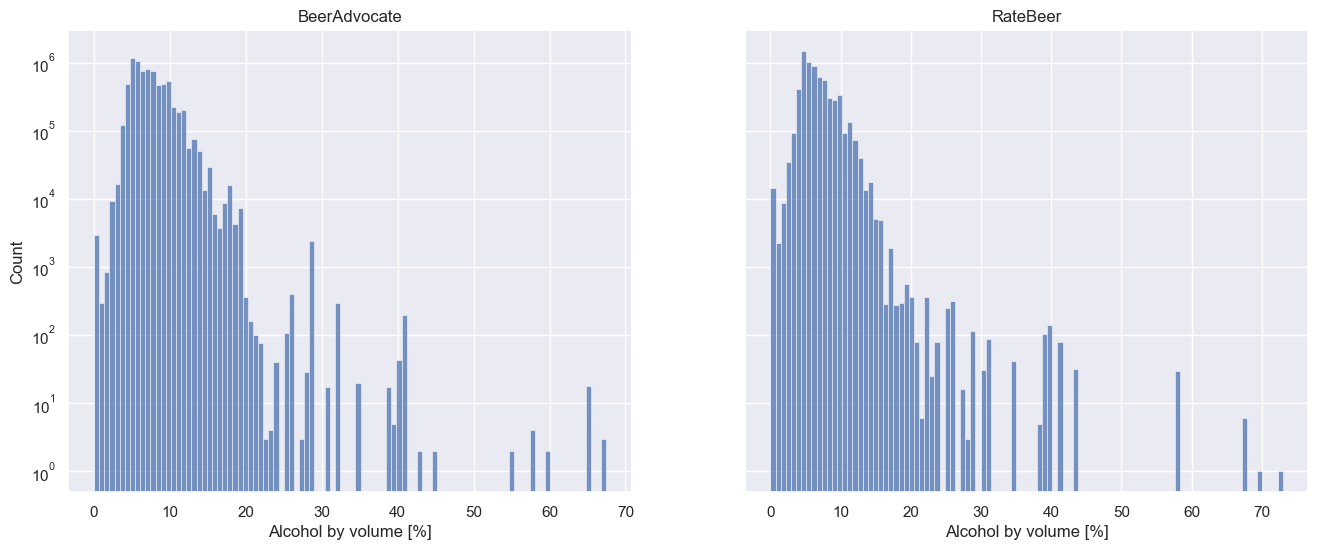

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.histplot(data=ba_df, x='abv', bins=100, ax=axes[0])
sns.histplot(data=rb_df, x='abv', bins=100, ax=axes[1])
axes[0].set(yscale='log', title="BeerAdvocate", xlabel="Alcohol by volume [%]")
axes[1].set(yscale='log', title="RateBeer", xlabel="Alcohol by volume [%]")

#### Observations: 
The number of reviews for the beers with ABV > 20% is small and the histogram shows sparse values for high ABV, meaning that there are only a few beers with such ABV. Because of that, we will consider all beers above 20% ABV as one catgory (as if they had the same ABV).

In [74]:
def round_and_max_abv(df, max_abv=20):
    rounded_abv_df = df[['rating', 'taste', 'palate', 'eu_na']].copy()
    rounded_abv_df['abv'] = df['abv'].round()
    rounded_abv_df['abv'] = rounded_abv_df['abv'].apply(lambda x: x if x < max_abv else max_abv)
    return rounded_abv_df


ba_rounded_abv_df = round_and_max_abv(ba_df)
rb_rounded_abv_df = round_and_max_abv(rb_df)

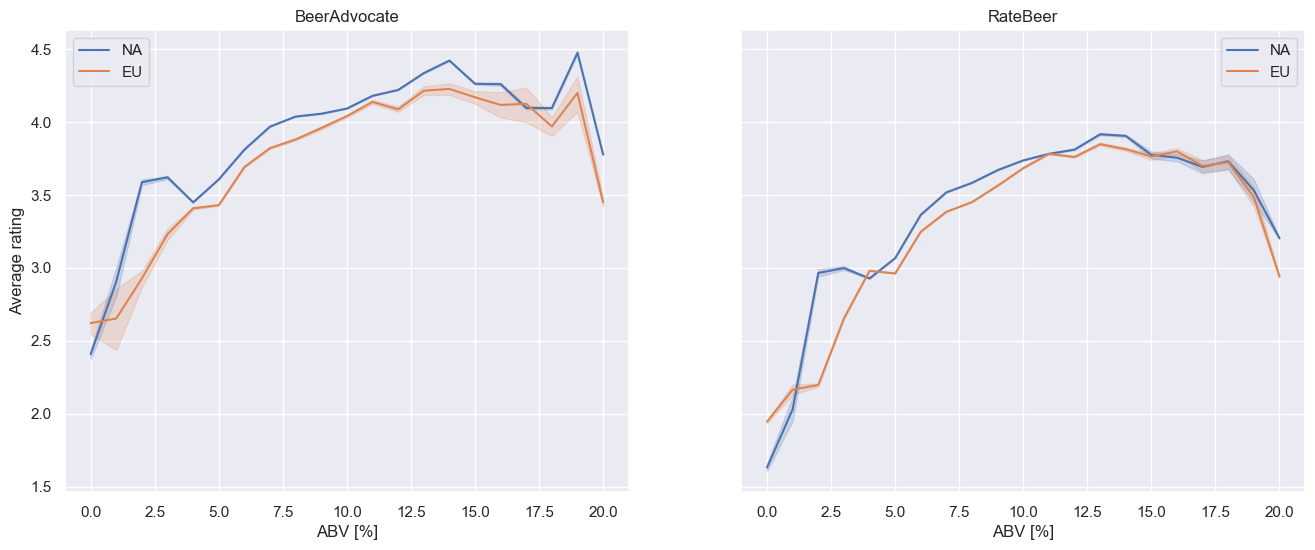

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

g1 = sns.lineplot(data=ba_rounded_abv_df, x='abv', y='rating', hue='eu_na', hue_order=hue_order, ax=axes[0])
g1.get_legend().set_title(None)
g2 = sns.lineplot(data=rb_rounded_abv_df, x='abv', y='rating', hue='eu_na', hue_order=hue_order, ax=axes[1])
g2.get_legend().set_title(None)

axes[0].set(xlabel="ABV [%]",
            ylabel="Average rating",
            title="BeerAdvocate")
axes[0].legend()

axes[1].set(xlabel="ABV [%]",
            title="RateBeer")
axes[1].legend()

#### Observations:
We see that in general, North American users tend to give better ratings than European users for beers with ABV < 15%, but this tendency is inverted for stronger (on BeerAdvocate) or disappears (on Ratebeer). However, as we will see below, North Americans user tend to give better ratings if we do not consider the ABV. This could point to a difference in taste that depends on the ABV between NA and EU users. We need to dig deeper into this!

To try to explain the plot above, let's take a look at the different beer styles and their average ABV, as well as their average ratings.
First the average ratings per style:

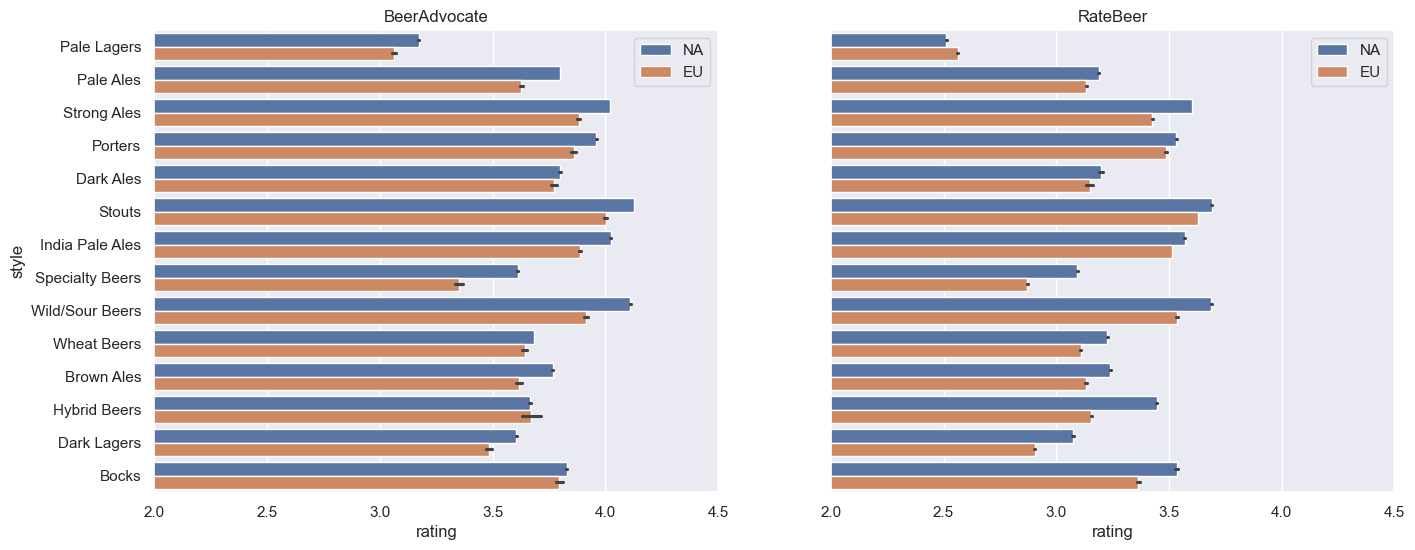

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

p1 = sns.barplot(data=ba_df, x='rating', y='style', hue='eu_na', hue_order=hue_order, ax=axes[0])
p1.get_legend().set_title(None)
axes[0].set(title='BeerAdvocate', xlim=(2, 4.5))
axes[0].legend(loc='upper right')

p2 = sns.barplot(data=rb_df, x='rating', y='style', hue='eu_na', hue_order=hue_order, ax=axes[1])
p2.get_legend().set_title(None)
axes[1].set(title='RateBeer', xlim=(2, 4.5))
axes[1].legend(loc='upper right')

And now ABV per style:

[Text(0.5, 1.0, 'RateBeer')]

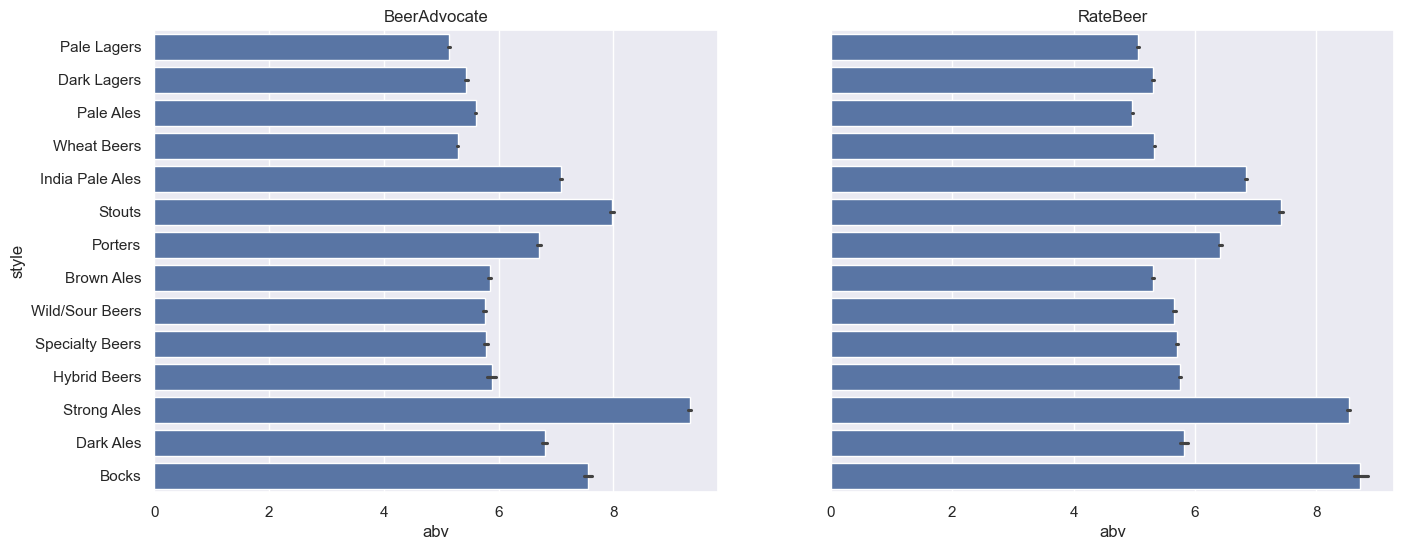

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

p1 = sns.barplot(data=ba_style_abv_df, x='abv', y='style', ax=axes[0])
axes[0].set(title='BeerAdvocate')

p2 = sns.barplot(data=rb_style_abv_df, x='abv', y='style', ax=axes[1])
axes[1].set(title='RateBeer')

# Need to have the same order as the plot above

#### Observations:
We see that some beer styles are significantly stronger than others. If these styles are consumed more frequently on one of the two continents compared to the other, then this could explain some differences in the way ratings are correlated with ABV.

Now let's look at the number of ratings per beer style. It will highlight a problem with one of the dataset:

[Text(0.5, 1.0, 'RateBeer')]

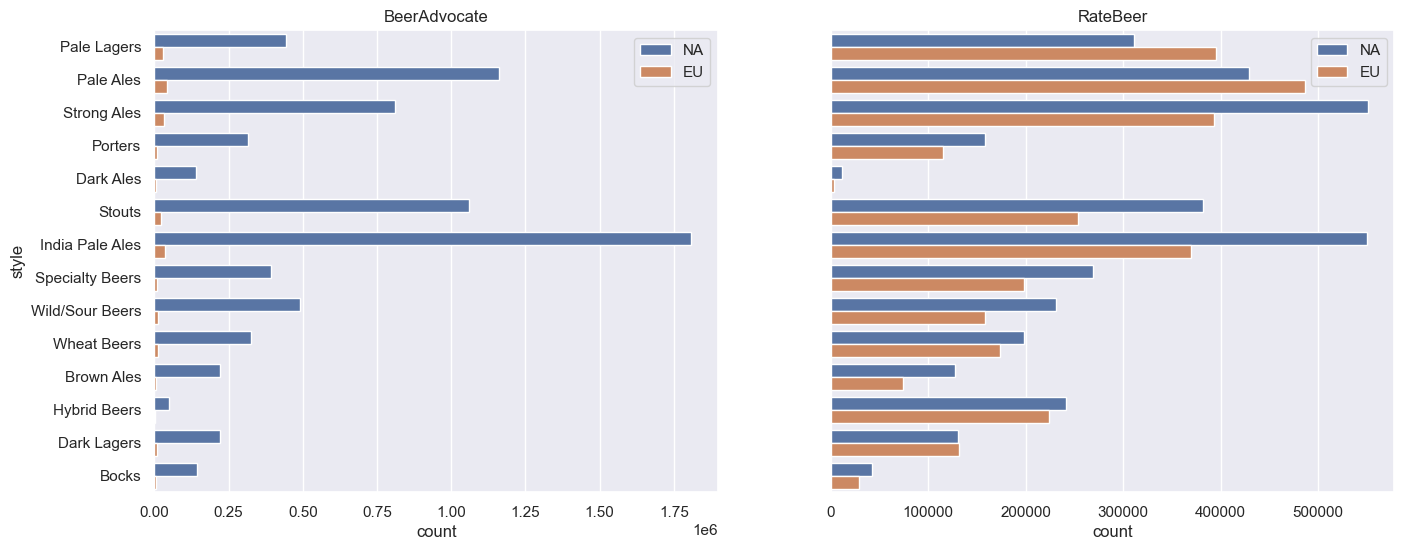

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

p1 = sns.countplot(data=ba_df, y='style', hue='eu_na', hue_order=hue_order, ax=axes[0])
p1.get_legend().set_title(None)
axes[0].legend(loc='upper right')
axes[0].set(title='BeerAdvocate')

p2 = sns.countplot(data=rb_df, y='style', hue='eu_na', hue_order=hue_order, ax=axes[1])
p2.get_legend().set_title(None)
axes[1].legend(loc='upper right')
axes[1].set(title='RateBeer')

#### Observation:
We are really lacking data from European users. We are considering dropping this dataset entirely. See the last part of the ReadMe.md.

#### 3.2 Evolution over time

In the following, we compare the ratings for both datasets BeerAdvocate and RateBeer over time

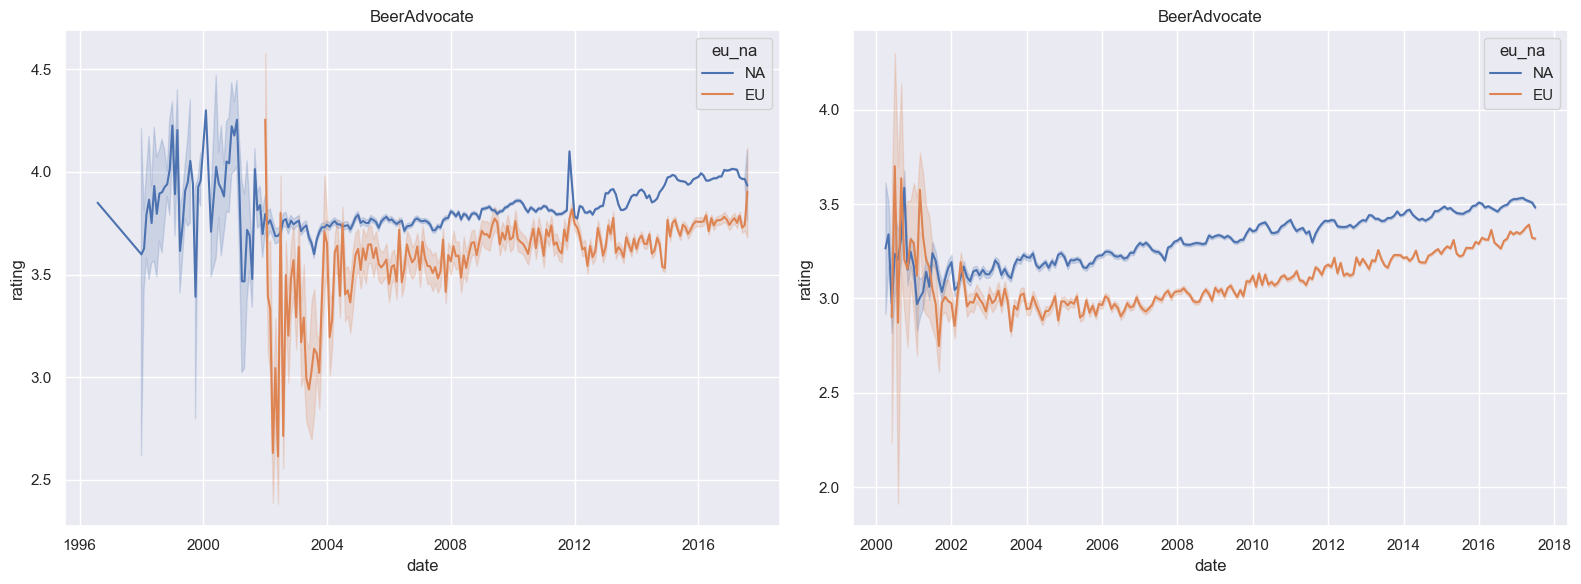

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=ba_df, x='date', y='rating', hue='eu_na', hue_order=hue_order, ax=axes[0])
sns.lineplot(data=rb_df, x='date', y='rating', hue='eu_na', hue_order=hue_order, ax=axes[1])
axes[0].set(title='BeerAdvocate')
axes[1].set(title='BeerAdvocate')

plt.tight_layout()
plt.show()

# rescale y axis


In [80]:
# Evaluating mean ratings

ba_NA_mean_rating = ba_df.query("eu_na == 'NA'")['rating'].mean()
ba_EU_mean_rating = ba_df.query("eu_na == 'EU'")['rating'].mean()
ba_mean_tot = ba_df['rating'].mean()

rb_NA_mean_rating = rb_df.query("eu_na == 'NA'")['rating'].mean()
rb_EU_mean_rating = rb_df.query("eu_na == 'EU'")['rating'].mean()
rb_mean_tot = rb_df['rating'].mean()

print(f'The mean rating in BeerAdvocate is {ba_mean_tot:.2f}.\n'
      f'The mean rating in RateBeer is {rb_mean_tot:.2f}.\n'
      f'The mean difference between EU and NA in BeerAdvocate is {ba_NA_mean_rating - ba_EU_mean_rating:.2f}.\n'
      f'The mean difference between EU and NA in RateBeer is {rb_NA_mean_rating - rb_EU_mean_rating:.2f}.\n')

The mean rating in BeerAdvocate is 3.88.
The mean rating in RateBeer is 3.29.
The mean difference between EU and NA in BeerAdvocate is 0.21.
The mean difference between EU and NA in RateBeer is 0.17.


BeerAdvocate receives better reviews on average than RateBeer, but the difference between NA and EU user ratings remains the same, where Europeans give harsher ratings on average. There's much more noise initially due to fewer reviews per month

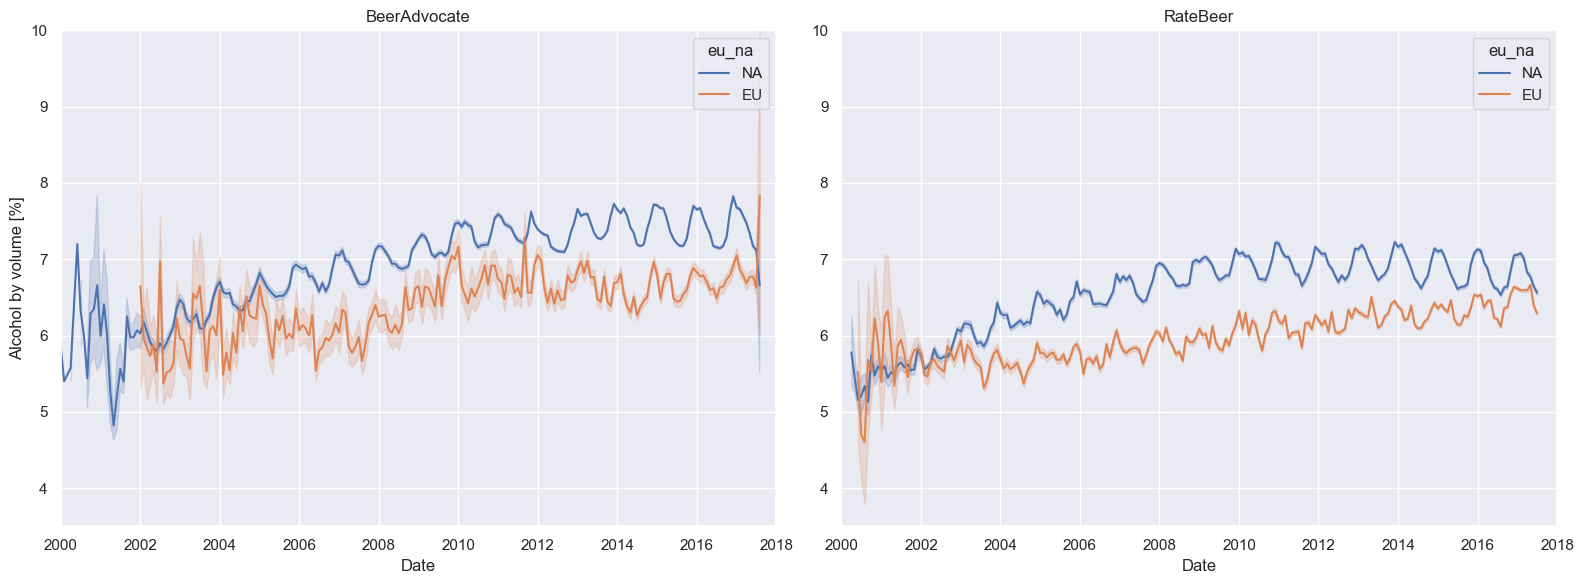

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
hue_order_na = ['NA', 'EU']
sns.lineplot(data=ba_df, x='date', y='abv', hue='eu_na', hue_order=hue_order_na, ax=axes[0])
sns.lineplot(data=rb_df, x='date', y='abv', hue='eu_na', hue_order=hue_order_na, ax=axes[1])
axes[0].set(xlabel="Date",
            ylabel="Alcohol by volume [%]",
            title="BeerAdvocate",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(3.5, 10))

axes[1].set(xlabel="Date",
            ylabel="",
            title="RateBeer",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(3.5, 10))

plt.tight_layout()
plt.show()

### Observations

- North American consumers consumes stronger beers on average than Europeans
- There is a high aspect of seasonality within ABV, which is more distinct in NA than Europe
- The ABV increases over time, for NA's it started flattening down in the 2010s



Let's now compare differences between alcohol content in styles in NA and EU:

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Alcohol by volume [%]'),
 Text(0.5, 1.0, 'RateBeer Europe'),
 (10957.0, 17532.0),
 (2.0, 14.0)]

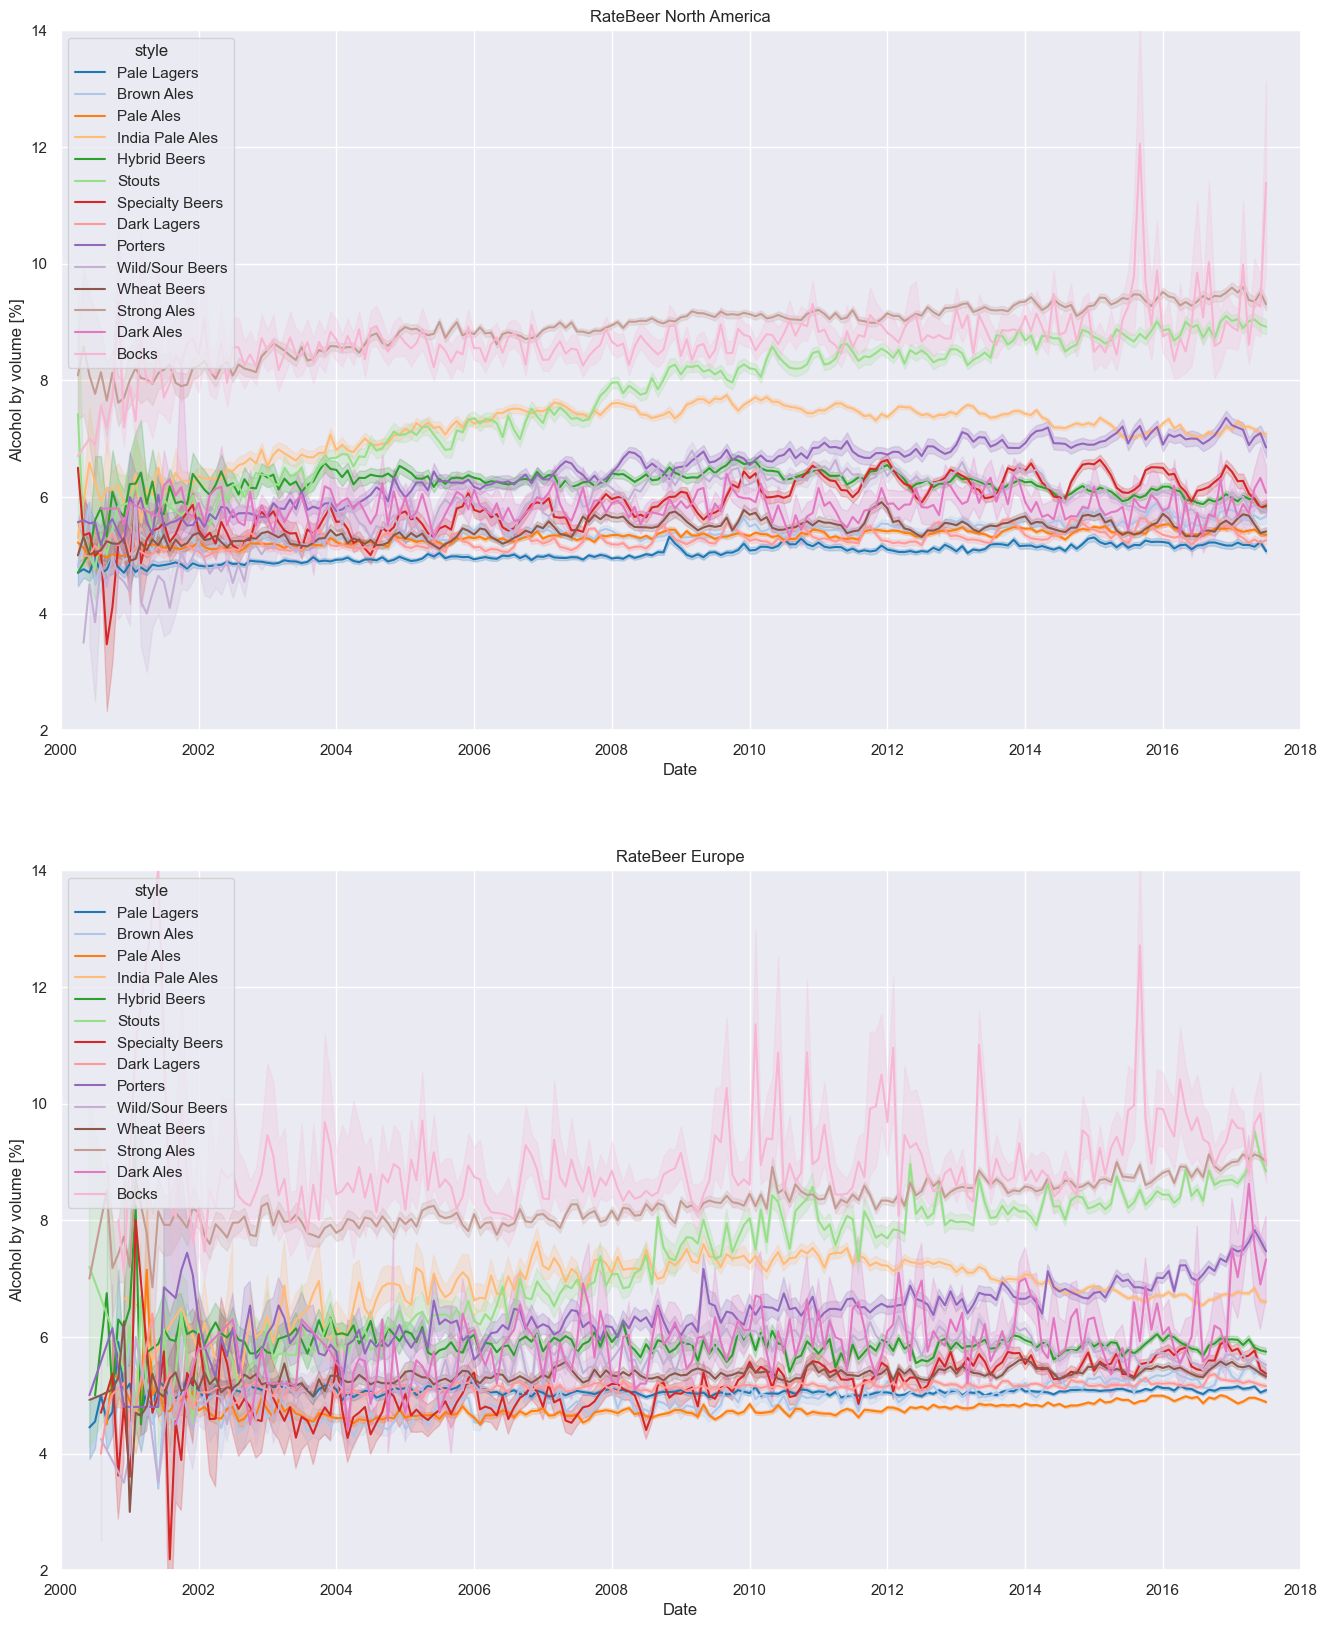

In [82]:
# Only considering RateBeer for now

fig, axes = plt.subplots(2, 1, figsize=(16, 20))

sns.lineplot(data=rb_df.query("eu_na == 'NA'"), x='date', y='abv', hue='style',
             hue_order=hue_order_styles, ax=axes[0], palette='tab20')
sns.lineplot(data=rb_df.query("eu_na == 'EU'"), x='date', y='abv', hue='style',
             hue_order=hue_order_styles, ax=axes[1], palette='tab20')
axes[0].set(xlabel="Date",
            ylabel="Alcohol by volume [%]",
            title="RateBeer North America",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(2, 14))

axes[1].set(xlabel="Date",
            ylabel="Alcohol by volume [%]",
            title="RateBeer Europe",
            xlim=(pd.Timestamp('2000-01-01'), pd.Timestamp('2018-01-01')),
            ylim=(2, 14))

#### Observations:
When considering all the beer styles within the data, one observes seasonality within some styles such as Specialty beer or Dark ales. It is also apparent that some beer styles such as Stouts increased drastically in average ABV over time. 
We also notice that some styles seem to differ in ABV on average in both continents, we may want to look for the reason behinf this.